In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Ensure you run this code in an environment where PyTorch GPU support is available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

OUTPUT_DIR = "shakespeare_works"
combined_text_file = "combined_shakespeare.txt"


Using device: cuda


In [2]:
combined_text = ""
for filename in os.listdir(OUTPUT_DIR):
    with open(os.path.join(OUTPUT_DIR, filename), "r", encoding="utf-8") as file:
        combined_text += file.read().strip() + "\n\n"

with open(combined_text_file, "w", encoding="utf-8") as file:
    file.write(combined_text)
print(f"Combined texts saved to {combined_text_file}")

Combined texts saved to combined_shakespeare.txt


In [3]:
# Load combined text
with open(combined_text_file, "r", encoding="utf-8") as file:
    text = file.read()

# Create character mappings
chars = sorted(set(text))
char_to_idx = {char: idx for idx, char in enumerate(chars)}
idx_to_char = {idx: char for idx, char in enumerate(chars)}

# Convert text to int representation
text_as_int = np.array([char_to_idx[char] for char in text])

# Sequence preparation
seq_length = 100
examples_per_epoch = len(text) - seq_length

inputs = []
targets = []
for i in range(examples_per_epoch):
    inputs.append(text_as_int[i:i+seq_length])
    targets.append(text_as_int[i+seq_length])

inputs = np.array(inputs)
targets = np.array(targets)

In [7]:
# Create a PyTorch Dataset
class ShakespeareDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = ShakespeareDataset(inputs, targets)

batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)


# Define the PyTorch model
class ShakespeareModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super(ShakespeareModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm1 = nn.LSTM(embedding_dim, rnn_units, batch_first=True)
        self.lstm2 = nn.LSTM(rnn_units, rnn_units, batch_first=True)
        self.fc = nn.Linear(rnn_units, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.fc(x)
        return x

vocab_size = len(chars)
embedding_dim = 256
rnn_units = 512

model = ShakespeareModel(vocab_size, embedding_dim, rnn_units).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20
loss_history = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for batch_inputs, batch_targets in dataloader:
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

        optimizer.zero_grad()
        # forward pass
        outputs = model(batch_inputs)
        # reshape outputs and targets for CrossEntropyLoss: (batch*seq, vocab)
        # outputs = outputs.view(-1, vocab_size)
        outputs = outputs[:, -1, :]
        batch_targets = batch_targets.view(-1)
        
        # Now [64, vocab_size]

# targets is [64]
        loss = criterion(outputs, batch_targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")


# Text generation function in PyTorch
def generate_text(model, start_string, num_generate=500, temperature=1.0):
    model.eval()
    input_eval = torch.tensor([char_to_idx[char] for char in start_string], dtype=torch.long).unsqueeze(0).to(device)
    text_generated = []

    with torch.no_grad():
        for _ in range(num_generate):
            outputs = model(input_eval)
            outputs = outputs[:, -1, :] / temperature
            probs = torch.softmax(outputs, dim=-1)
            predicted_id = torch.multinomial(probs, num_samples=1).item()

            text_generated.append(idx_to_char[predicted_id])
            # Append the predicted character to the input sequence
            input_eval = torch.cat([input_eval[:, 1:], torch.tensor([[predicted_id]], device=device)], dim=1)

    return start_string + ''.join(text_generated)


seed_text = "To be, or not to be, that is the question:"
generated_text = generate_text(model, seed_text, num_generate=1000)
print(generated_text)


Epoch 1/20, Loss: 1.7513
Epoch 2/20, Loss: 1.3531
Epoch 3/20, Loss: 1.2095
Epoch 4/20, Loss: 1.1099
Epoch 5/20, Loss: 1.0243
Epoch 6/20, Loss: 0.9479
Epoch 7/20, Loss: 0.8775
Epoch 8/20, Loss: 0.8072
Epoch 9/20, Loss: 0.7484
Epoch 10/20, Loss: 0.6933
Epoch 11/20, Loss: 0.6432
Epoch 12/20, Loss: 0.6003
Epoch 13/20, Loss: 0.5607
Epoch 14/20, Loss: 0.5282
Epoch 15/20, Loss: 0.5053
Epoch 16/20, Loss: 0.4795
Epoch 17/20, Loss: 0.4628
Epoch 18/20, Loss: 0.4486
Epoch 19/20, Loss: 0.4370
Epoch 20/20, Loss: 0.4336
To be, or not to be, that is the question:              30

He crack'd my voice fair'd again,          30

but wander-proofferenger's arrested to lise by all

the sealing on trainscrite of luce's sap,

Thirty-making upon succost: in less in eart,

My will and in my poor dishoney,

And as a Contry in my house, go with me,

Mistress this belive bound, being by.



_Luc._ Not my money benefice, Stauntaunt, and the five gues,

Go to seek deeparaction is deform the rope's name

        dis

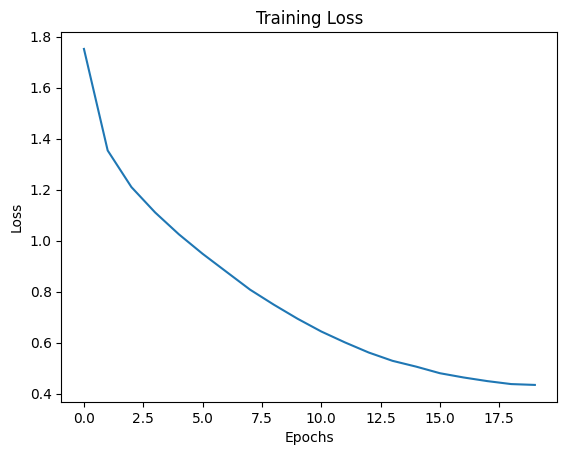

Model saved as shakespeare_generator.pth


In [8]:
# Plotting the loss
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

# Saving the model
torch.save(model.state_dict(), "shakespeare_generator.pth")
print("Model saved as shakespeare_generator.pth")

In [10]:
import math
perplexity = math.exp(loss.item())
print("Perplexity:", perplexity)


Perplexity: 1.5813847991596877
